In [10]:
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry

from astropy.io import fits
import numpy as np

from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
basepath = '/orange/adamginsburg/w51/TaehwaYoo/jwst_w51/'
image_filenames_pipe ={
    "f140m":basepath+"F140M/pipeline/jw06151-o001_t001_nircam_clear-f140m-merged_i2d.fits",
    "f150w": basepath+"F150M/pipeline/jw06151-o001_t001_nircam_clear-f150w-merged_i2d.fits",
    "f182m": basepath+"F182M/pipeline/jw06151-o001_t001_nircam_clear-f182m-merged_i2d.fits",
    "f187n": basepath+"F187N/pipeline/jw06151-o001_t001_nircam_clear-f187n-merged_i2d.fits",
    "f210m": basepath+"F210M/pipeline/jw06151-o001_t001_nircam_clear-f210m-merged_i2d.fits",
    "f335m": basepath+"F335M/pipeline/jw06151-o001_t001_nircam_clear-f335m-merged_i2d.fits",
    "f360m": basepath+"F360M/pipeline/jw06151-o001_t001_nircam_clear-f360m-merged_i2d.fits",
    "f405n": basepath+"F405N/pipeline/jw06151-o001_t001_nircam_clear-f405n-merged_i2d.fits",
    "f410m": basepath+"F410M/pipeline/jw06151-o001_t001_nircam_clear-f410m-merged_i2d.fits",
    "f480m": basepath+"F480M/pipeline/jw06151-o001_t001_nircam_clear-f480m-merged_i2d.fits",
}




In [11]:
data_140m = fits.open(image_filenames_pipe["f140m"])
# use simple sigma clipping
data = data_140m[1].data   
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(mean, median, std)

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(data, threshold, npixels=10)
footprint = circular_footprint(radius=10)
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print(mean, median, std)

0.74609756 0.73022455 0.23895103
0.70409346 0.6960242 0.09989103


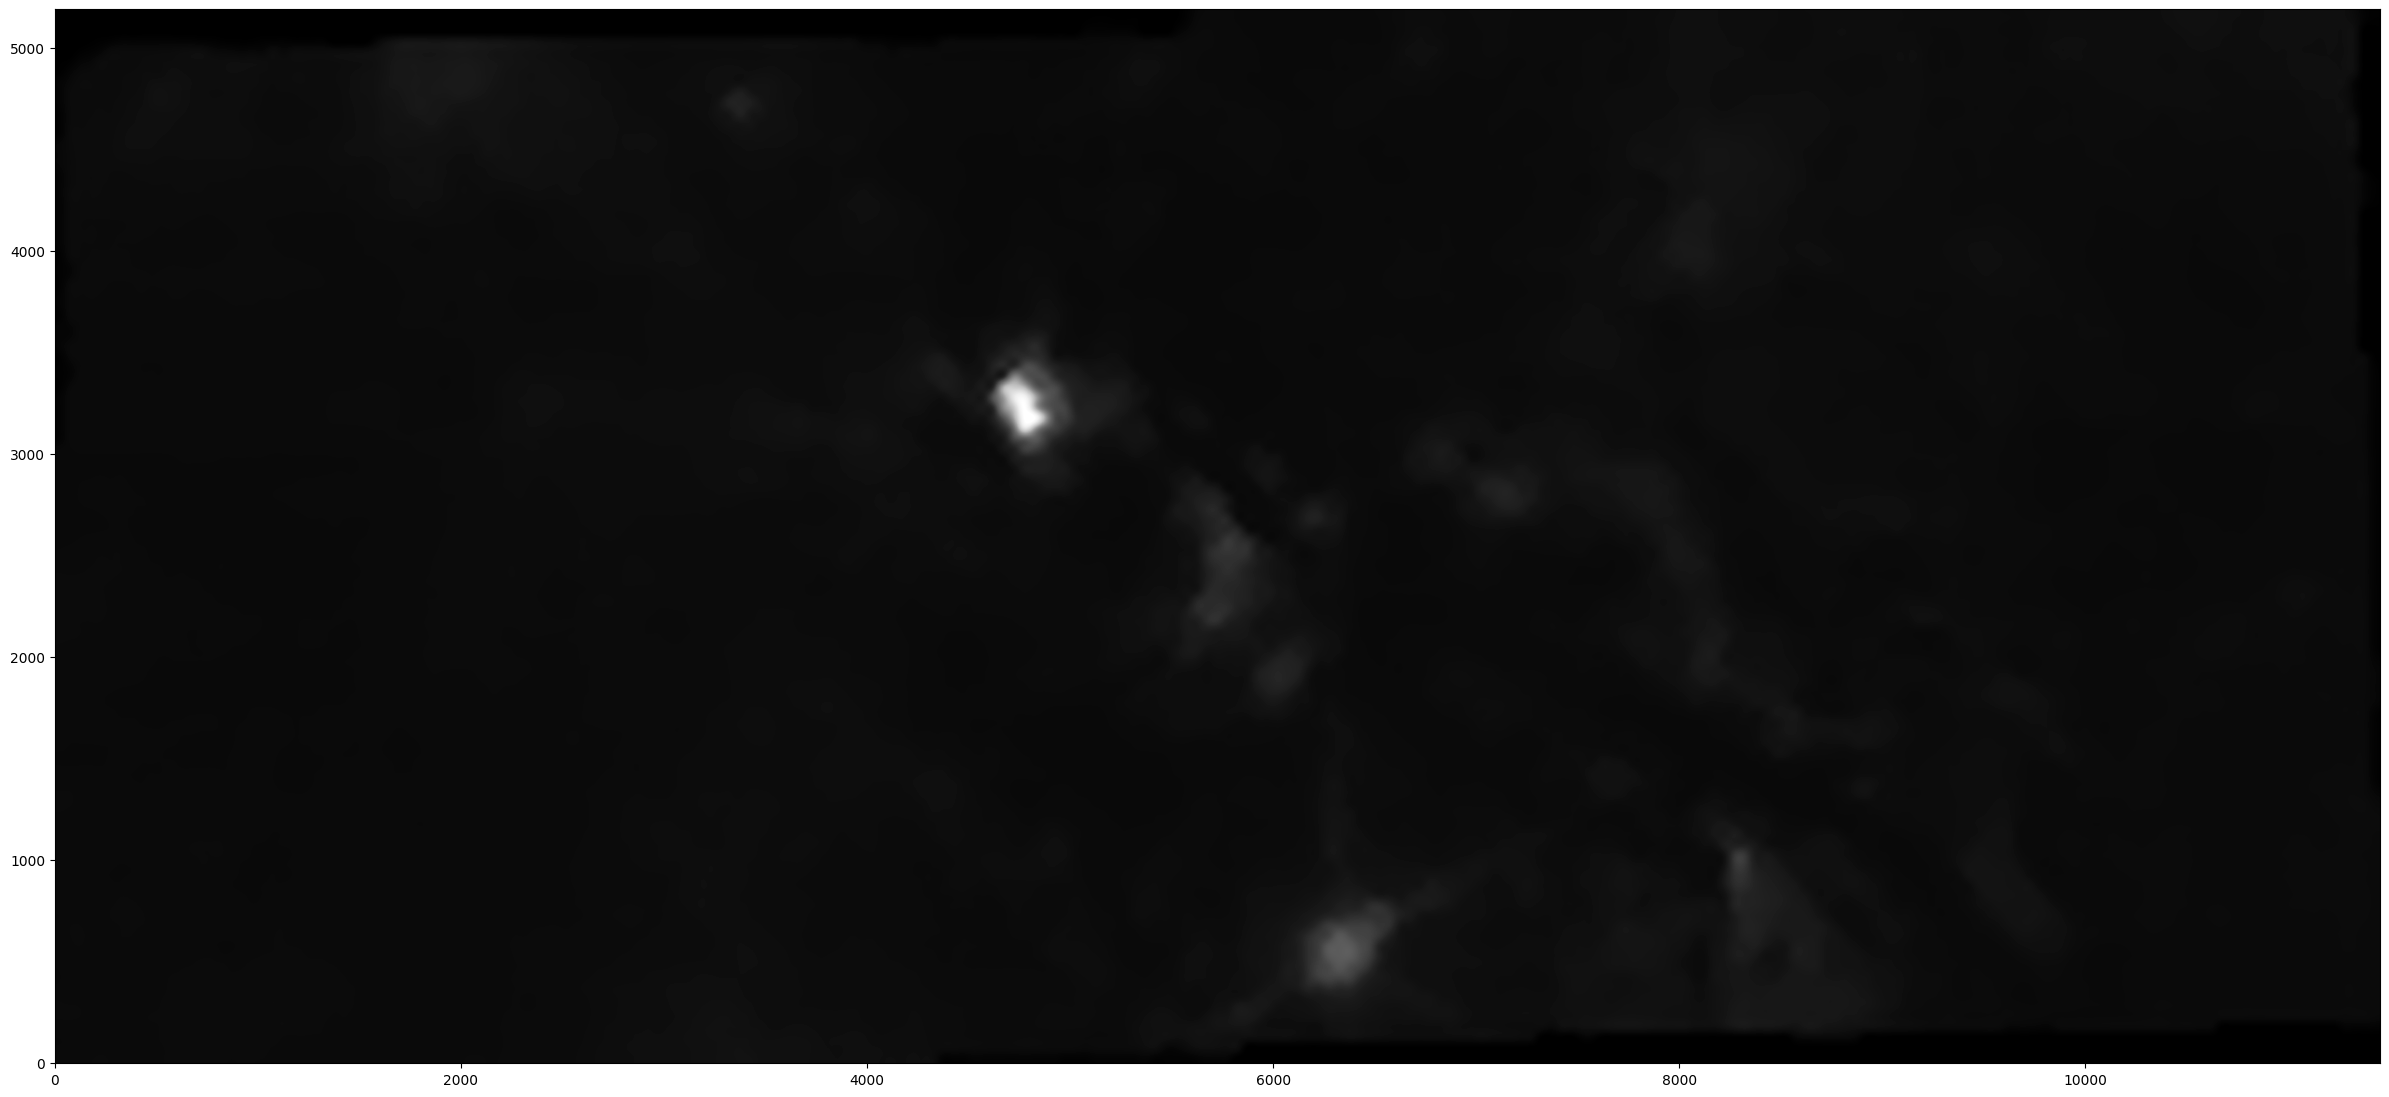

In [13]:
from photutils.background import Background2D, MedianBackground
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
fig = plt.figure(figsize=(30, 30))
plt.imshow(bkg.background, origin='lower', cmap='Greys_r', 
           interpolation='nearest')


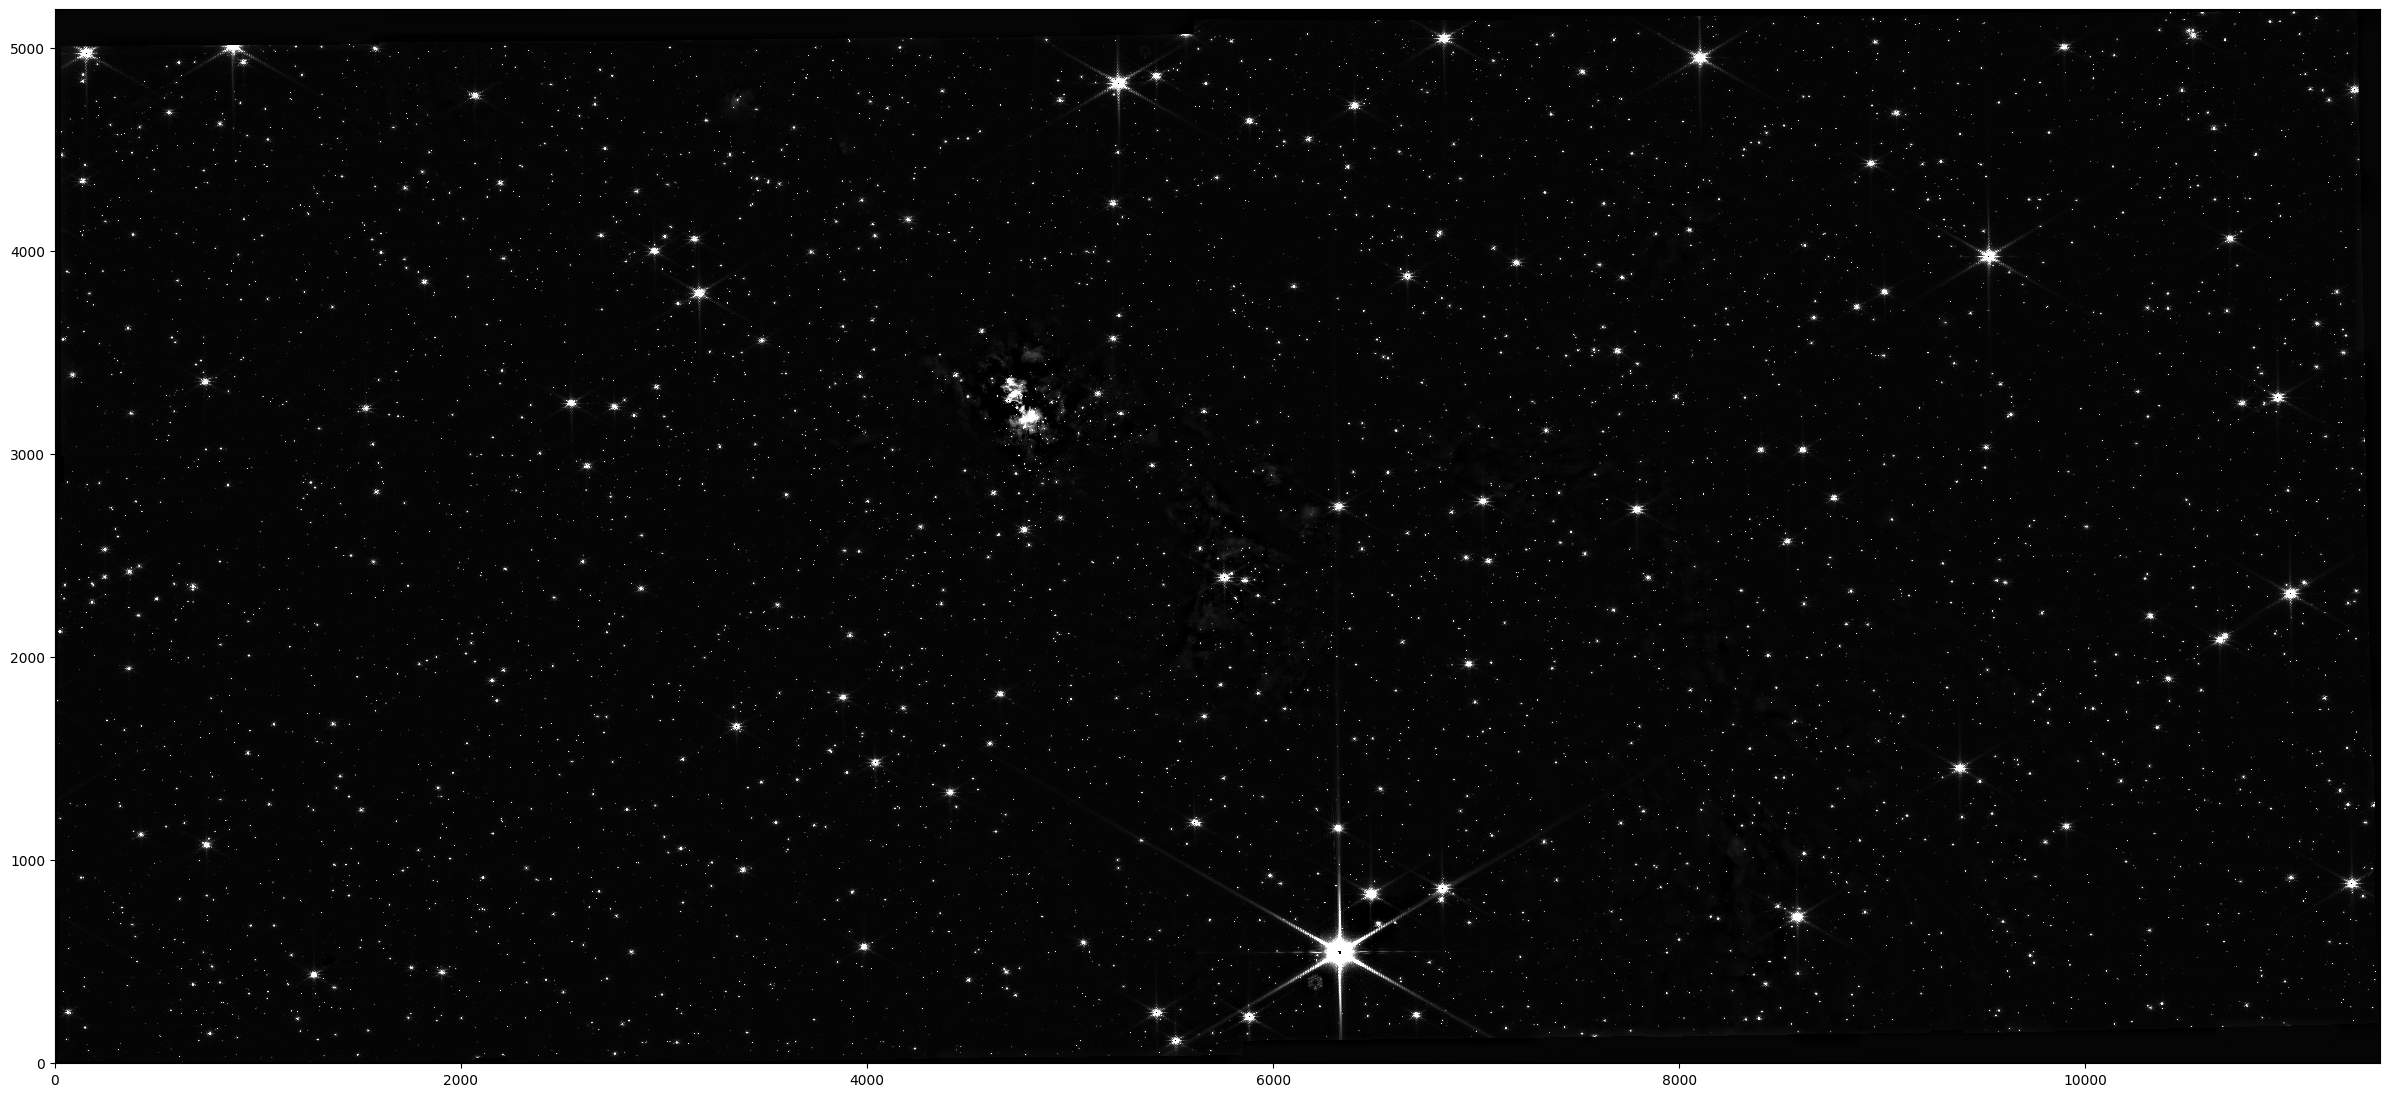

In [15]:
fig = plt.figure(figsize=(30, 30))

plt.imshow(data-bkg.background, origin='lower', cmap='Greys_r', vmin=-0.538734148035978, vmax=26,
           interpolation='nearest')

In [17]:
from photutils.psf import CircularGaussianPRF
psf_model = CircularGaussianPRF(flux=1, fwhm=2.7)
fit_shape = (5, 5)
finder = DAOStarFinder(6.0, 2.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=4)
error = median
phot = psfphot(data-bkg.background)

In [19]:
resid = psfphot.make_residual_image(data-bkg.background)

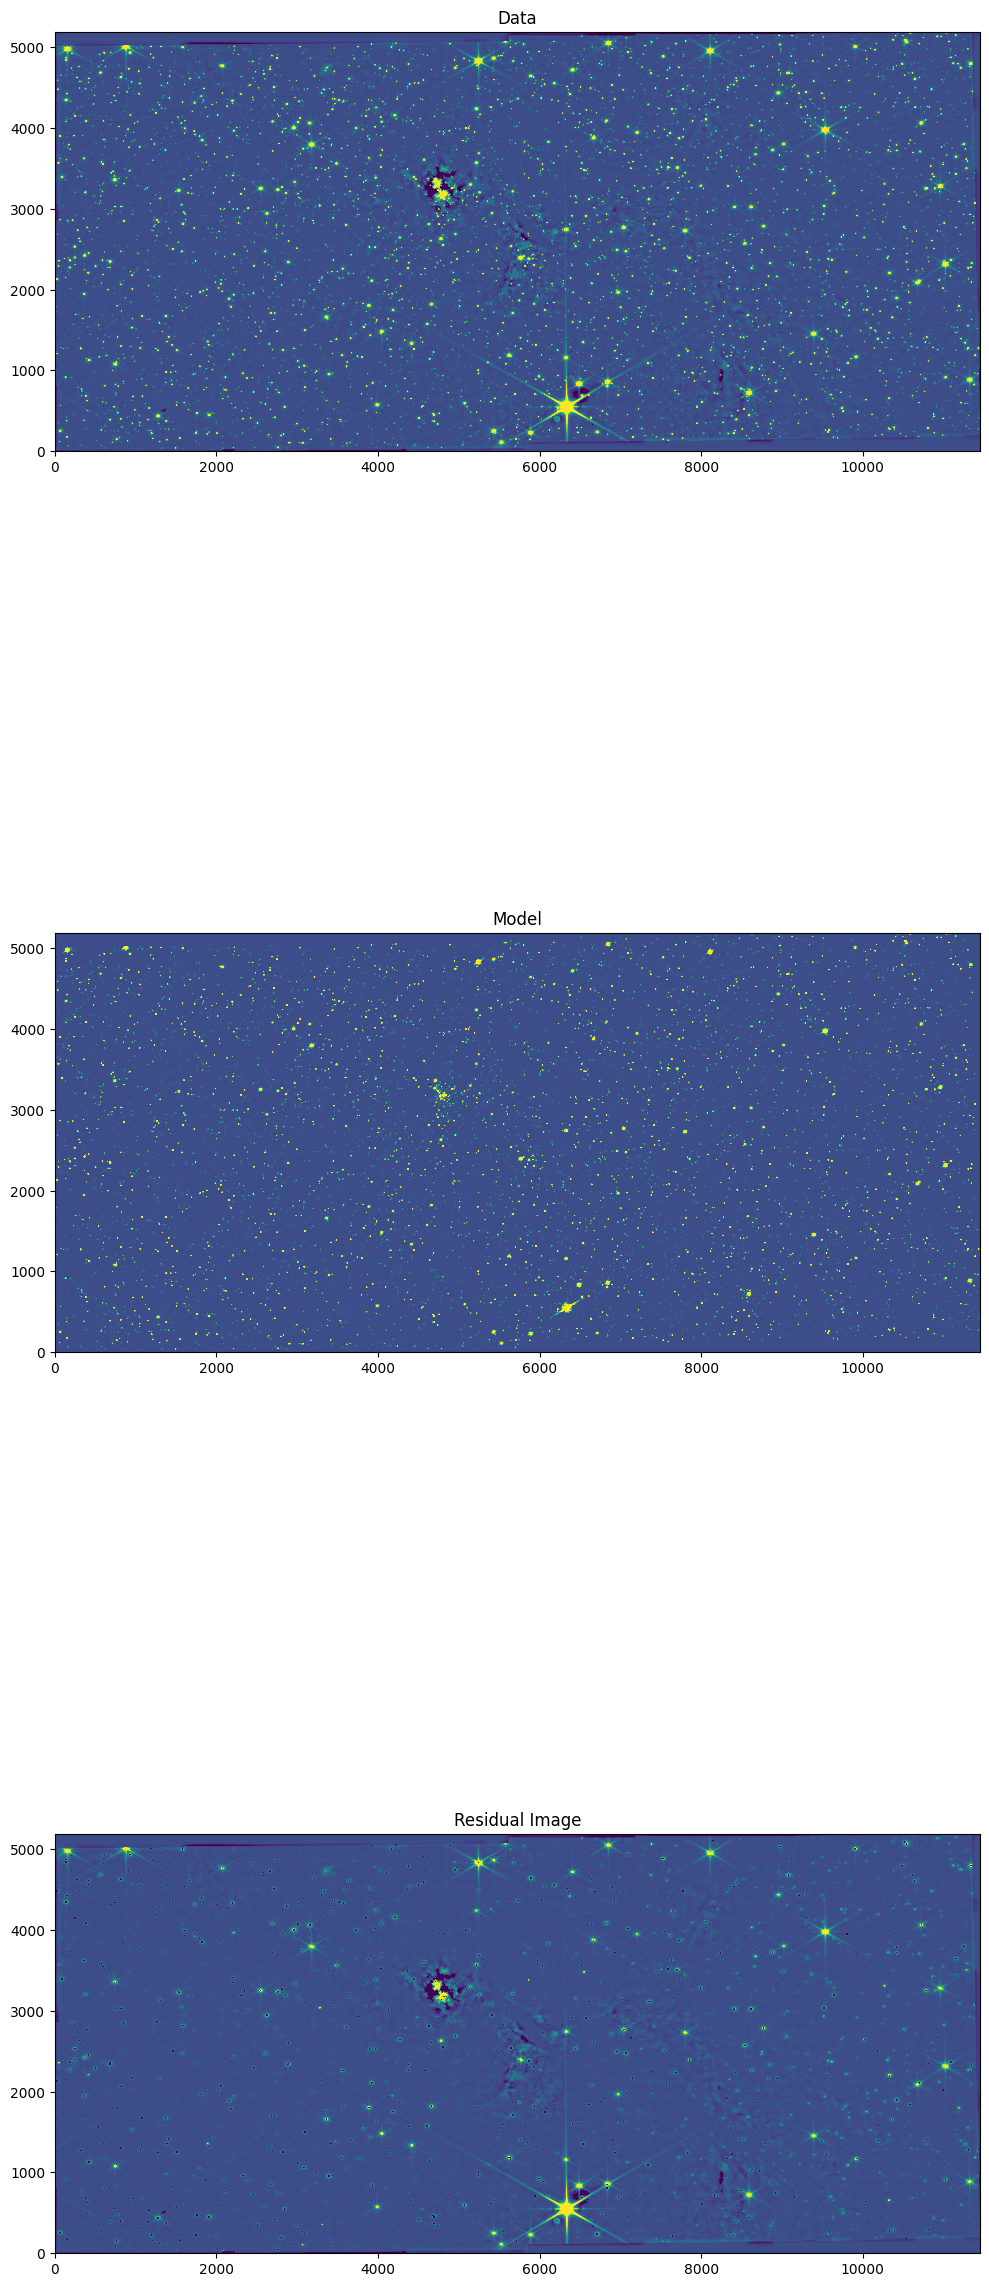

In [26]:
from astropy.visualization import simple_norm

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 30))
norm = simple_norm(data-bkg.background, 'sqrt', percent=99)
ax[0].imshow(data-bkg.background, origin='lower', norm=norm)
ax[1].imshow(data-bkg.background - resid, origin='lower', norm=norm)
im = ax[2].imshow(resid, origin='lower', norm=norm)
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
plt.tight_layout()

In [20]:
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')])

  id        x_fit              y_fit             flux_fit     
----- ------------------ ------------------ ------------------
    1   239.428975058503 15.298995343478436 106.83867751849112
    2 1013.8823834573876 23.417582531904173 254.00049475168072
    3  2595.848931063561  22.70539952999963 43.179359528331744
    4 3088.3489530724332 23.360906872569245 54.115655026923086
    5  1583.478859691724 24.863682773147307  180.3131682398056
    6 1942.7675779306192   24.8851961582965  74.13862750713439
    7 2470.9503608371188 25.083430380048462  92.06338781034174
    8 1067.7543053616307 28.402793915258332 401.17692612713597
    9  2077.292481509321 28.163959540584305 160.72467238035608
   10  3598.336172326987  28.42256931287197  73.55453676037071
  ...                ...                ...                ...
16647 11027.232234237896  5167.113189186129  782.4851669727445
16648 10419.888362852917  5167.421224487845  2247.857681337855
16649 10759.104730179253  5167.993320302091  682.699675